## Multi-step forecasting

We want to predict / forecast multiple steps ahead.

### Direct forecasting

* 1 model per forecasting point.
* 1 target per forecasting point

We Train a model per forecasting point. Each forecasting point is estimated independently.

### Cons 
* Multiple models
* Computational cost
* Forecast are independent

### Pros
* Less estimation variance
* Does not propagate estimation errors





In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.datetime import DatetimeFeatures

## Data

In [30]:
df = pd.read_csv('../../Datasets/AirQualityUCI_ready.csv',
 parse_dates=['Date_Time'], index_col=['Date_Time'], usecols=['RH','CO_sensor','Date_Time'])

df.sort_index(inplace=True)

df = df.loc["2004-04-01":"2005-04-30"]

df = df.loc[df['CO_sensor']>0]

df.head()

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


## Feature Engineering Pipeline

In [31]:
date_feat =  DatetimeFeatures(variables='index', 
            features_to_extract=['month', 'hour', 'week', 'day_of_week', 'day_of_month','weekend'])

cyclic_feat = CyclicalFeatures(variables=['hour', 'month'])

lag_feat = LagFeatures(variables=['CO_sensor', 'RH'], freq=['1H','24H'], missing_values='ignore')

window_feat = WindowFeatures(variables=['CO_sensor', 'RH'], freq='1H', window='3H', missing_values='ignore')

drop_missing = DropMissingData()

drop_feat = DropFeatures(features_to_drop=['CO_sensor', 'RH'])

pipe = Pipeline([ 
    ('Date features', date_feat),
    ('Cyclic features', cyclic_feat),
    ('Lag features', lag_feat),
    ('window features', window_feat),
    ('drop missing', drop_missing),
    ('drop features', drop_feat),
])

## Train Test Split

In [32]:
train = df.loc[:df.index.max() - pd.Timedelta(value='31D')]
test = df[df.index.max() - pd.Timedelta(value='32D'):]

In [33]:
y_train = df.loc[train.index, ['CO_sensor']]
y_test = df.loc[test.index, ['CO_sensor']]

## Prepare the target for Direct Forecasting

In the direct approach, we build a model to predict each one of the steps in the forecasting horizon.

This means that we need to create suitable targets first:

- 1 hour ahead
- 2 hour ahead
- 3 hour ahead

...

- 24 hour ahead.

In [34]:
forecast_horizon = 24

y_train_df = pd.DataFrame(index=y_train.index)
y_test_df = pd.DataFrame(index=y_test.index)

for i in range(forecast_horizon):
    y_train_df[f'y_{i}']=y_train.shift(periods=-i, freq='H')
    y_test_df[f'y_{i}']=y_test.shift(periods=-i, freq='H')

In [35]:
y_train_df.tail()

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,...,y_14,y_15,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-04 10:00:00,970.0,1000.0,996.0,928.0,933.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-04 11:00:00,1000.0,996.0,928.0,933.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-04 12:00:00,996.0,928.0,933.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-04 13:00:00,928.0,933.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-04 14:00:00,933.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Drop the missing data

In [36]:
# drop the missing 

y_train_df.dropna(inplace=True)
y_test_df.dropna(inplace=True)

In [37]:
train = train.loc[y_train_df.index]
test = test.loc[y_test_df.index]

In [38]:
assert y_train_df.index.min() == train.index.min() and y_train_df.index.max() == train.index.max()

In [39]:
print('missing values present') if all(y_train_df.isna().sum() > 0) else print('No missing values present')

No missing values present


## Apply feature engineering pipeline

In [40]:
X_train = pipe.fit_transform(train)
X_test = pipe.transform(test)

In [41]:
print('Start index X_train :',X_train.index.min(),'\nStart index y_train :',y_train_df.index.min())
print('Index end X_train :',X_train.index.max(),'\nIndex end y_train :',y_train_df.index.max())

Start index X_train : 2004-04-05 00:00:00 
Start index y_train : 2004-04-04 00:00:00
Index end X_train : 2005-03-03 15:00:00 
Index end y_train : 2005-03-03 15:00:00


In [42]:
y_train_df = y_train_df.loc[X_train.index]
y_test_df = y_test_df.loc[X_test.index]

In [43]:
print('Start index X_train :',X_train.index.min(),'\nStart index y_train :',y_train_df.index.min())
print('Index end X_train :',X_train.index.max(),'\nIndex end y_train :',y_train_df.index.max())

Start index X_train : 2004-04-05 00:00:00 
Start index y_train : 2004-04-05 00:00:00
Index end X_train : 2005-03-03 15:00:00 
Index end y_train : 2005-03-03 15:00:00


## Modeling - Lasso

In [44]:
# Lasso regression

# Using the MultiOutputRegressor, we automatically create
# one Lasso for each target.

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Lasso, MultiTaskLasso


lasso = MultiOutputRegressor(Lasso())
lasso.fit(X_train, y_train_df)
y_pred = lasso.predict(X_test)

print('Shape of y_pred', y_pred.shape)

y_pred_df = pd.DataFrame(data=y_pred, columns=y_test_df.columns)


Shape of y_pred (425, 24)


In [45]:

mse = []
mae = []
y_i = []
for i in range(forecast_horizon):
    mse.append(mean_squared_error(y_test_df[f'y_{i}'], y_pred_df[f'y_{i}']))
    mae.append(mean_absolute_error(y_test_df[f'y_{i}'], y_pred_df[f'y_{i}']))
    y_i.append(f'y_{i}')


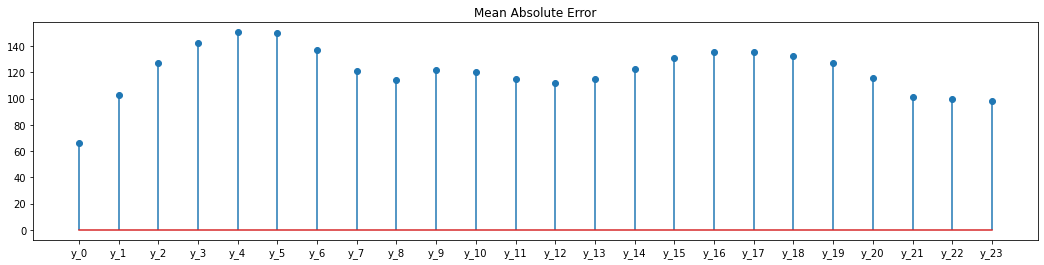

In [46]:
plt.figure(figsize=(18,4))
plt.stem(y_i, mae)
plt.title('Mean Absolute Error');

## Visualize the predictions

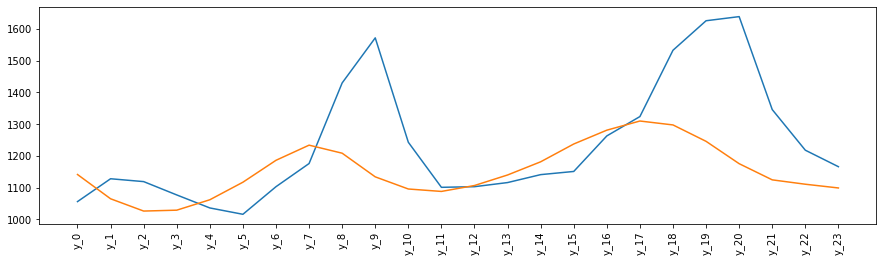

In [47]:
plt.figure(figsize=(15, 4))
plt.plot(y_test_df.iloc[0,:], label='y-true')
plt.plot(y_pred[0,:], label='y-pred')
plt.xticks(rotation=90);

## Lasso model - coefs 

We can fit a lasso model for every target y in the y_train_df and collect the coefs

In [48]:
print('Shape of X_train :',X_train.shape)
print('Shape of y_train_df :',y_train_df.shape)

Shape of X_train : (5784, 16)
Shape of y_train_df : (5784, 24)


We have 16 features and 24 tasks to fit.

Lets fit 24 lasso models and collect the coefs and visualize

In [49]:
lasso_coefs = np.array([Lasso().fit(X_train, y).coef_ for y in y_train_df.values.T])
print(lasso_coefs.shape)

(24, 16)


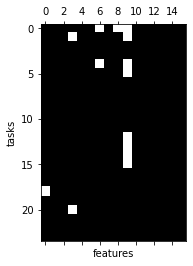

In [50]:
# Non zero - coefs
plt.spy(lasso_coefs);
plt.xlabel('features')
plt.ylabel('tasks');


## Multi Task Lasso

In [51]:
multi_task_lasso = MultiTaskLasso()
multi_task_lasso.fit(X_train, y_train_df)
y_pred = multi_task_lasso.predict(X_test)

print('Shape of y_pred', y_pred.shape)

y_pred_df = pd.DataFrame(data=y_pred, columns=y_test_df.columns)

score = {}
for i in range(forecast_horizon):
    mse = mean_squared_error(y_test_df[f'y_{i}'], y_pred_df[f'y_{i}'])
    mae = mean_absolute_error(y_test_df[f'y_{i}'], y_pred_df[f'y_{i}'])
    score[f'y_{i}'] = {'mse':mse, 'mae':mae}

Shape of y_pred (425, 24)


In [52]:
score

{'y_0': {'mse': 8757.368063722392, 'mae': 66.07720283475298},
 'y_1': {'mse': 21754.652546797694, 'mae': 103.17895585411266},
 'y_2': {'mse': 32093.283521422585, 'mae': 127.37887437976286},
 'y_3': {'mse': 37460.707017919434, 'mae': 142.39049583819352},
 'y_4': {'mse': 39125.442385065704, 'mae': 149.8850486962671},
 'y_5': {'mse': 37186.442863846605, 'mae': 149.17130023450073},
 'y_6': {'mse': 31305.846553812826, 'mae': 136.22264360670684},
 'y_7': {'mse': 24550.834013417483, 'mae': 119.6438945022591},
 'y_8': {'mse': 22682.67431017133, 'mae': 113.35095867012066},
 'y_9': {'mse': 25430.404282249376, 'mae': 120.9264517529346},
 'y_10': {'mse': 24240.741241557094, 'mae': 119.22771879800018},
 'y_11': {'mse': 22809.60675733672, 'mae': 114.2722689598002},
 'y_12': {'mse': 23570.98543887992, 'mae': 110.59051458685136},
 'y_13': {'mse': 26440.149913838693, 'mae': 114.08256063585516},
 'y_14': {'mse': 30416.84565361761, 'mae': 120.95985565421654},
 'y_15': {'mse': 33769.68260343135, 'mae': 12

The multi-task lasso allows to fit multiple regression problems jointly enforcing the selected features to be the same across tasks.

Text(0, 0.5, 'tasks')

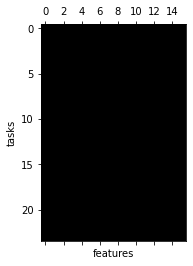

In [53]:

plt.spy(multi_task_lasso.coef_);
plt.xlabel('features')
plt.ylabel('tasks')

## Visualize prediction 

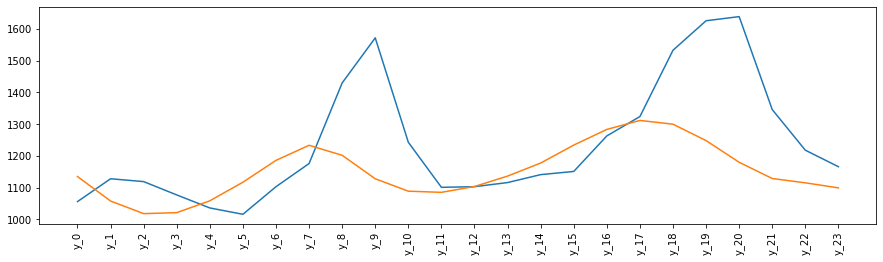

In [54]:
plt.figure(figsize=(15, 4))
plt.plot(y_test_df.iloc[0,:], label='y-true')
plt.plot(y_pred[0,:], label='y-pred')
plt.xticks(rotation=90);